# Starting with a Simple Example: Digits Data from sklearn
Let's start our adventure into convolutional networks with a simple example of the digits dataset. This was not always such a simple example, but modern day computing power and open source tools has made it a significantly more tractable problem. 

Note that we will not be using the `tf.data` format for these example since they are sufficiently small enough to work with. 

Moreover, we will employ the sequential API in keras, which assumes that the output from the previous operation becomes the input to the next operation. Thus, we can build feedforward networks by simply adding operations in a list. Specifically, we will use the `model.add( )` function.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

print('Tensorflow version:',tf.__version__)
print('Keras version:', keras.__version__)

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results more reproducible
print(tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.16.2
Keras version: 3.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def load_digits():
    
    digits = datasets.load_digits()
    
    # NORMALIZATION, VERY IMPORTANT, Like we showed in Neural Network Lab
    X = digits.data.astype(np.float32)/16.0 - 0.5
    y = digits.target.astype(np.int32)
    
    X = X.reshape((X.shape[0],8,8,1)) # reshape as images
    # the image data has been resized to (samples, image_rows, image_cols, image_channels)
    
    # Split it into train / test subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # and one hot encoding the output values
    NUM_CLASSES = 10
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe  = keras.utils.to_categorical(y_test, NUM_CLASSES)
        
    # create a dataset 
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe))
    ds_train = ds_train.shuffle(1024) # buffer size for shuffle
    ds_train = ds_train.batch(128)

    ds_test  = tf.data.Dataset.from_tensor_slices((X_test, y_test_ohe))
    ds_test = ds_test.batch(128)
    
    return ds_train, ds_test

ds_train, ds_test = load_digits()


2025-11-13 12:07:25.845290: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-13 12:07:25.845308: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-13 12:07:25.845313: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-13 12:07:25.845327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-13 12:07:25.845335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-11-13 12:07:26.181669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Image size: (8, 8, 1) , Classes: 10


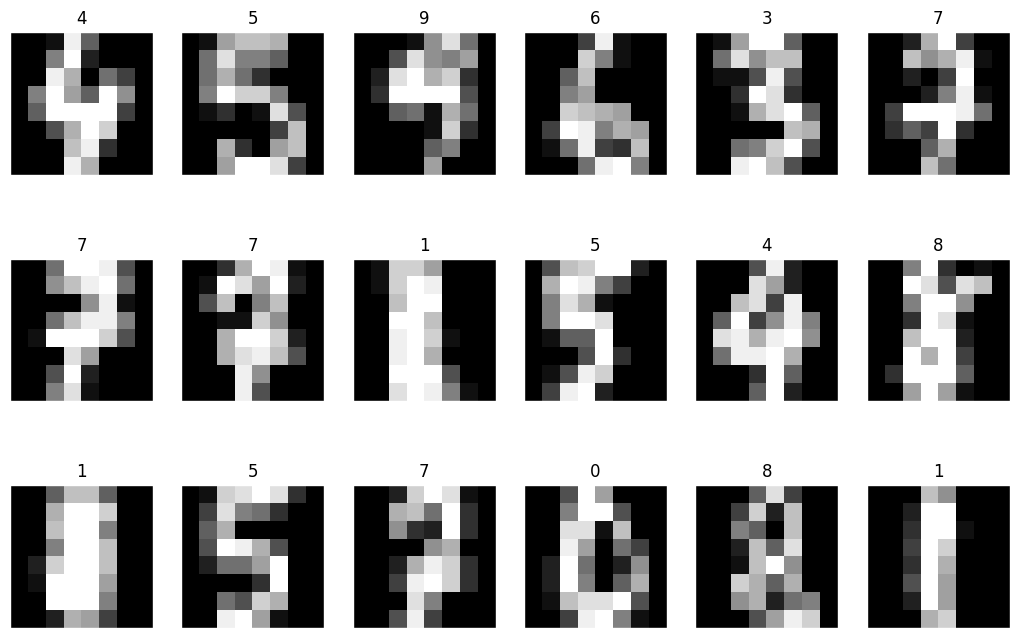

In [3]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

[(img_sample_tf, label_sample_tf)] = ds_train.take(1)

NUM_CLASSES = label_sample_tf.shape[1] # get one hot encoding dimension for the number of classes
img_wh = img_sample_tf[0].shape[0] # get the width and height for the image
print('Image size:',img_sample_tf[0].shape,', Classes:',NUM_CLASSES)

# provide some image for plotting as a gallery using this batch
plot_gallery(img_sample_tf.numpy(), np.argmax(label_sample_tf.numpy(),axis=1), 8, 8) # defaults to showing a 3 by 6 subset of the images



____
# A very Simple ConvNet Versus a Raw Pixel Input MLP
Wouldn't it be great if we did not need to specify the correct filters (like in DAISY)? What if we could just let the weights of the convolution be found through neural network training methods. Of course, we can! Let's do one example with a simple CNN architecture and compare it to the performance of a pixel wise MLP.

In general, the flattened images placed through a MLP can be quite accurate (as we have seen in the past). Even so, using convolitional filters and pooling should provide us with some better resilience to small perturbations in the images. 

**BONUS**: Let's start using the sequential API, rather than the funcitonal API. Also, we can use numpy matrices instead of the tf.data format for smaller examples. The format will mean that the models are not quite as fast for loading data, but since everythign fits in memory its not a huge concern. 

Note that, since we are not using tf.data, we need to normalize the input data directly, rather than as part of th model. 

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

keras.__version__

'3.5.0'

In [5]:
%%time

# CREATE A BASELINE MLP WITH THREE LAYERS

input_shape = [8,8,1]

# make a 3 layer keras MLP
mlp = Sequential(name='MLP')
mlp.add( Input(input_shape) )
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense( units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(ds_train, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

2025-11-13 12:07:26.585659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


CPU times: user 7.24 s, sys: 3.89 s, total: 11.1 s
Wall time: 8.2 s


In [6]:
%%time

# CREATE A CNN WITH ONLY ONE CONVOLUTIONAL LAYER AND ONE OUTPUT LAYER

# make a CNN with conv layer and max pooling
cnn = Sequential(name='2x2_Kernel') 
cnn.add( Input(input_shape) )
cnn.add( Conv2D(filters=16, 
                kernel_size= (2, 2), 
                padding='same', 
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

print(cnn.summary())


/Users/eclarson/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "2x2_Kernel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 16)       │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,650 (10.35 KB)

 Trainable params: 2,650 (10.35 KB)

 Non-trainable params: 0 (0.00 B)

None
CPU times: user 28.7 ms, sys: 4.94 ms, total: 33.7 ms
Wall time: 50.5 ms


In [7]:
%%time 


# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.fit(ds_train, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 6.13 s, sys: 3.8 s, total: 9.93 s
Wall time: 7.54 s


In [8]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_models(models, ds_test, fig_size=(15,5), labels='auto'):
    ''' Plot confusion matrices for each model, with names
    '''
    plt.figure(figsize=fig_size)
    
    y_test = []
    for _, label_tensor in ds_test:
        # Convert the label tensor to a NumPy array and append it to the list
        y_test.append(label_tensor.numpy())
    y_test = np.argmax(np.vstack(y_test),axis=1) # stack into single array, get integer class

    # plot confusion matrices 
    num_plots = len(models)
    i = 1
    for model in models:
        yhat = np.argmax(model.predict(ds_test), axis=1)
        acc = mt.accuracy_score(y_test,yhat)

        cm = mt.confusion_matrix(y_test,yhat)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        
        plt.subplot(1,num_plots,i)
        
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels, yticklabels=labels)
        plt.title(f'{model.name}: {acc:.4f}')
        i += 1
    

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2025-11-13 12:07:42.879115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


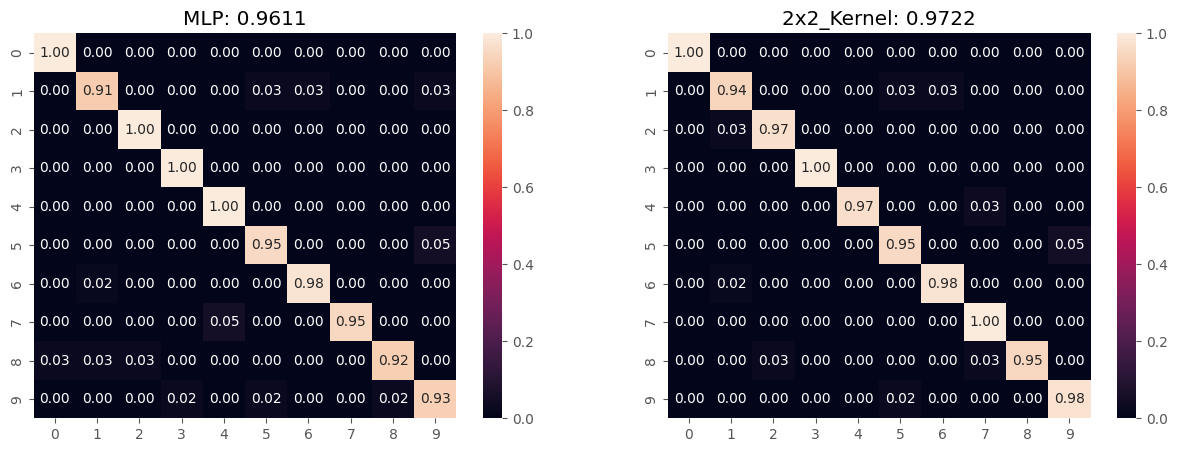

In [9]:
compare_models((mlp,cnn), ds_test)

____________
## Defining additional CNN Architectures
Now let's define a function to help us create different models to investigate with CNNs. We can customize various pieces such as the kernel size, pooling size, number of layers, filters per layer, and whether to use dropout. 
Now let's try a few different variations, train them and see how they perofrm compared to one another.

In [10]:
%%time

def create_cnn_model(model_name, input_shape = [8,8,1], kernel_size= (3,3), pool_size=(2,2), 
                     filters_per_conv_layer = [32], # number of filters to use and how many convolutional layers to use 
                     dense_layer_sizes = [10], # number of neurons in each layer after flattening
                     use_dropout=False
                    ):
    
    cnn  = Sequential(name=model_name)
    cnn.add( Input(input_shape) )
    
    # convolutional layers
    for num_filters in filters_per_conv_layer:
        cnn.add( Conv2D(filters=num_filters, 
                        kernel_size=kernel_size, 
                        padding='same',
                        activation='relu',
                         ) )
        
        cnn.add( MaxPooling2D(pool_size=pool_size) )

    cnn.add( Flatten() )
    if len(dense_layer_sizes) > 1:
        # if layers preceding the final number of classes, make relu
        for num_hidden in dense_layer_sizes[:-2]:
            cnn.add( Dense(num_hidden, activation='relu') )
            # optionally use Dropout
            if use_dropout: cnn.add( Dropout(0.5) )
    # final layer for classes
    cnn.add( Dense(dense_layer_sizes[-1], activation='softmax') )

    return cnn

# changes: 
#    1. increased kernel size

cnn2 = create_cnn_model(
    model_name  = '3by3_kernel',
    input_shape = [8,8,1],
    kernel_size = (3,3), 
    pool_size   = (2,2), 
    filters_per_conv_layer = [32], 
    dense_layer_sizes      = [10], 
    use_dropout = False
)

cnn3 = create_cnn_model(
    model_name  = '2_ConvLayer',
    input_shape = [8,8,1],
    kernel_size = (3,3), 
    pool_size   = (2,2), 
    filters_per_conv_layer = [32,32], 
    dense_layer_sizes      = [10], 
    use_dropout = False
)

cnn4 = create_cnn_model(
    model_name  = '2_ConvLayer_2Dense',
    input_shape = [8,8,1],
    kernel_size = (3,3), 
    pool_size   = (2,2), 
    filters_per_conv_layer = [16,32], 
    dense_layer_sizes      = [100,10], 
    use_dropout = True
)

for model in [cnn2,cnn3,cnn4]:
    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    model.fit(ds_train, 
            batch_size=32, epochs=150, 
            shuffle=True, verbose=0)


Model: "3by3_kernel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,450 (21.29 KB)

 Trainable params: 5,450 (21.29 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "2_ConvLayer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,858 (42.41 KB)

 Trainable params: 10,858 (42.41 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "2_ConvLayer_2Dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,090 (23.79 KB)

 Trainable params: 6,090 (23.79 KB)

 Non-trainable params: 0 (0.00 B)

None
CPU times: user 21.3 s, sys: 12.6 s, total: 34 s
Wall time: 26.2 s


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2025-11-13 12:08:09.454696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x30c88be20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2025-11-13 12:08:09.672907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


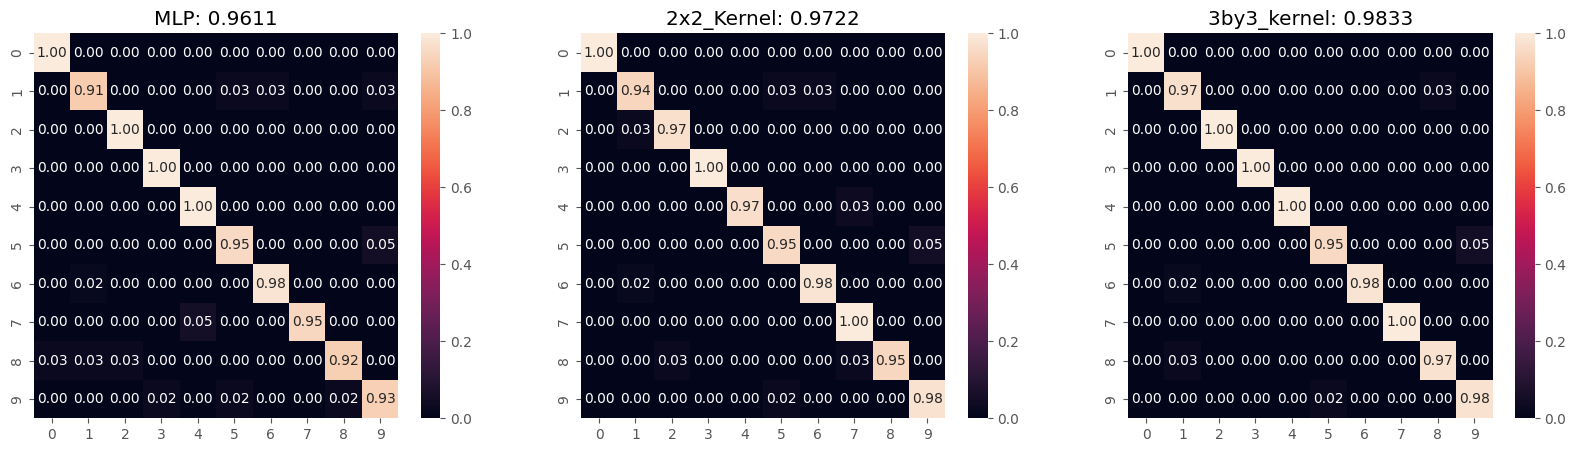

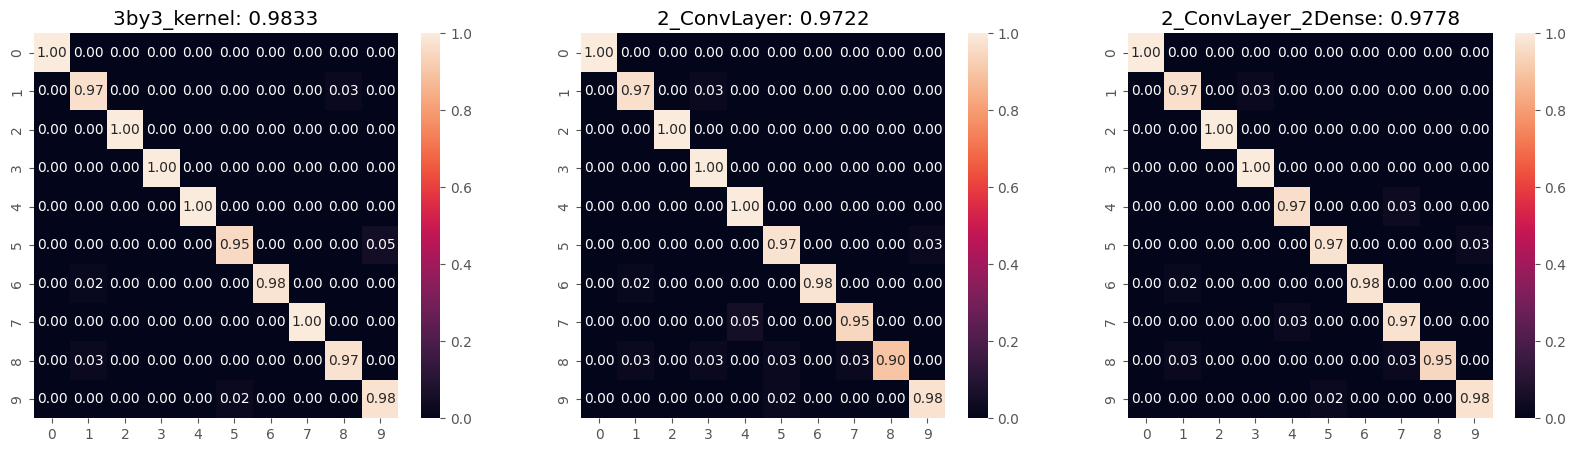

In [11]:
compare_models((mlp,cnn,cnn2), ds_test, fig_size=(20,5))
compare_models((cnn2,cnn3,cnn4), ds_test, fig_size=(20,5))

# Fashion MNIST
Okay, so we are honing in on the best performance for the digits data. But, we really need something a bit bigger to work on. Enter: Fashion MNIST. We have already used this dataset in the past, where we got about 84% accuracy with our custom MLP. Lets see how well Keras and tensorflow can perform!

Now let's load in a more diverse, harder to classify dataset: Fashion MNIST
https://www.kaggle.com/zalando-research/fashionmnist

**Labels**

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 

In [12]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train', is_test=False):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    # Let's start by fixing the sizes, channels last and normalizing
    images = images/255.0
    images = np.expand_dims(images.reshape((-1,28,28)), axis=3)
    # the image data has been resized to (samples,image_rows,image_cols,image_channels)
    
    # and one hot encoding the output values
    NUM_CLASSES = 10
    labels = keras.utils.to_categorical(labels, NUM_CLASSES)
    
    # create a dataset 
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if not is_test:
        # only shuffle the training set
        dataset = dataset.shuffle(1024) # buffer size for shuffeling data
    dataset = dataset.batch(128)
    
 
    return dataset

ds_train = load_mnist('data/', kind='fashion_train')
ds_test = load_mnist('data/', kind='fashion_t10k', is_test=True)

In [13]:
%%time

input_shape = [28,28,1]
# make a keras MLP
mlp = Sequential(name='FashionMLP')
mlp.add( Input(input_shape) )
mlp.add( Flatten() )
mlp.add( Dense(units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(mlp.summary())

mlp.fit(ds_train, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

Model: "FashionMLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,610 (338.32 KB)

 Trainable params: 86,610 (338.32 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7186 - loss: 0.8153
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8443 - loss: 0.4292
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8616 - loss: 0.3739
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8711 - loss: 0.3444
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8793 - loss: 0.3217
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8881 - loss: 0.3014
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8907 - loss: 0.2907
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8963 - loss: 0.2793
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8998 - loss: 0.2668
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9023 - loss: 0.2577
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9052 - loss: 0.2529
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-11-13 12:09:06.311248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


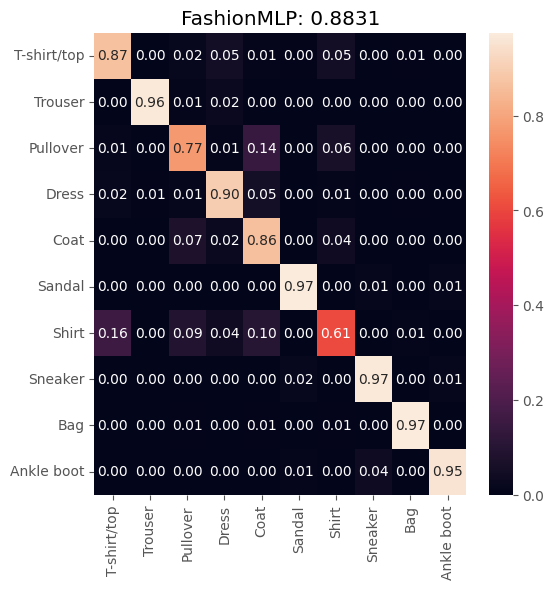

In [14]:
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
compare_models([mlp], ds_test, fig_size=(6,6), labels=labels)


In [15]:
%%time

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = create_cnn_model(
    model_name  = 'FashionConvSmall',
    input_shape = [28,28,1],
    kernel_size = (3,3), 
    pool_size   = (2,2), 
    filters_per_conv_layer = [32,32], 
    dense_layer_sizes      = [50,10], 
    use_dropout = False
)

cnn2 = create_cnn_model(
    model_name  = 'FashionConvLarge',
    input_shape = [28,28,1],
    kernel_size = (3,3), 
    pool_size   = (2,2), 
    filters_per_conv_layer = [32,64], 
    dense_layer_sizes      = [256,50,10], 
    use_dropout = True
)

for model in [cnn1,cnn2]:
    # Let's train the model 
    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    print(model.summary())
    
    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    history = model.fit(ds_train, 
            batch_size=32, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=ds_test)



Model: "FashionConvSmall"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        15,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,258 (98.66 KB)

 Trainable params: 25,258 (98.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6234 - loss: 0.0497 - val_accuracy: 0.7951 - val_loss: 0.0286
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8407 - loss: 0.0231 - val_accuracy: 0.8550 - val_loss: 0.0210
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8663 - loss: 0.0195 - val_accuracy: 0.8725 - val_loss: 0.0187
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8791 - loss: 0.0178 - val_accuracy: 0.8794 - val_loss: 0.0180
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8866 - loss: 0.0167 - val_accuracy: 0.8806 - val_loss: 0.0175
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8926 - loss: 0.0158 - val_accuracy: 0.8810 - val_loss: 0.0174
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8971 - loss: 0.0153 - val_accuracy: 0.8916 - val_loss: 0.0163
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9010 - loss: 0.0147 - val

Model: "FashionConvLarge"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 824,458 (3.15 MB)

 Trainable params: 824,458 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5859 - loss: 0.0528 - val_accuracy: 0.8231 - val_loss: 0.0248
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8305 - loss: 0.0243 - val_accuracy: 0.8549 - val_loss: 0.0206
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8571 - loss: 0.0206 - val_accuracy: 0.8616 - val_loss: 0.0198
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8699 - loss: 0.0190 - val_accuracy: 0.8766 - val_loss: 0.0179
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8804 - loss: 0.0175 - val_accuracy: 0.8840 - val_loss: 0.0165
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8859 - loss: 0.0165 - val_accuracy: 0.8917 - val_loss: 0.0157
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8931 - loss: 0.0156 - val_accuracy: 0.8920 - val_loss: 0.0158
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8979 - loss: 0.0149 - val

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2025-11-13 12:12:20.691902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


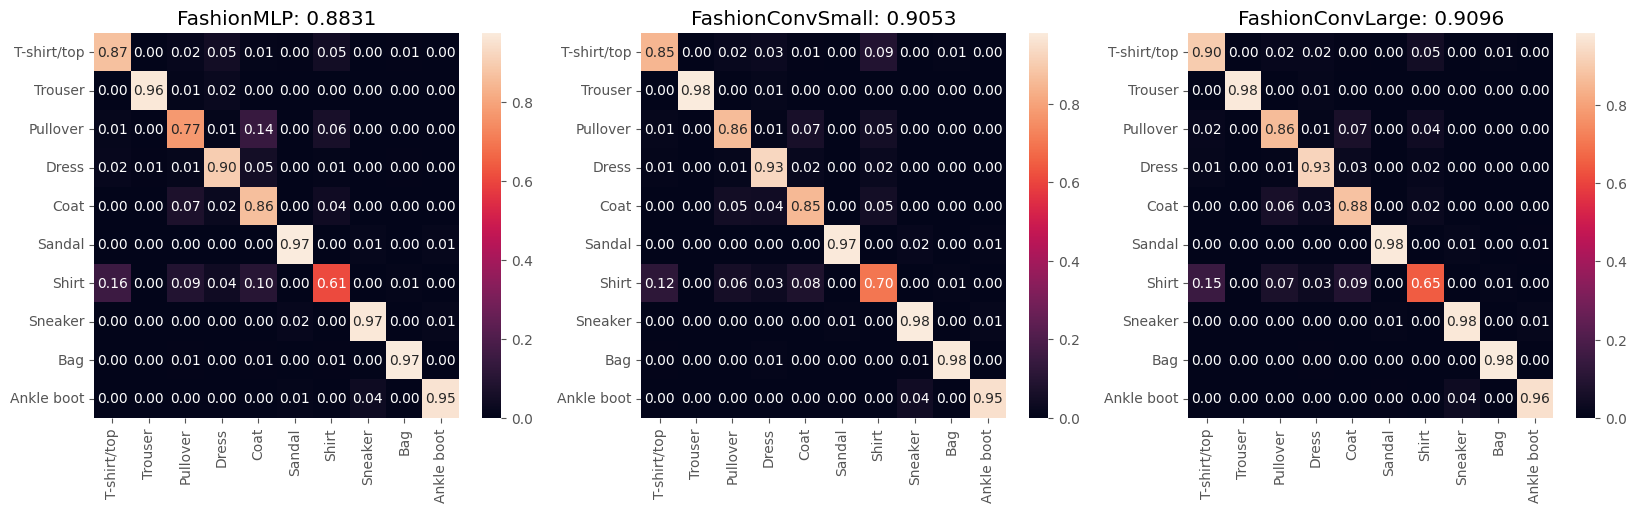

In [16]:
compare_models((mlp,cnn1,cnn2), ds_test, fig_size=(20,5), labels=labels)

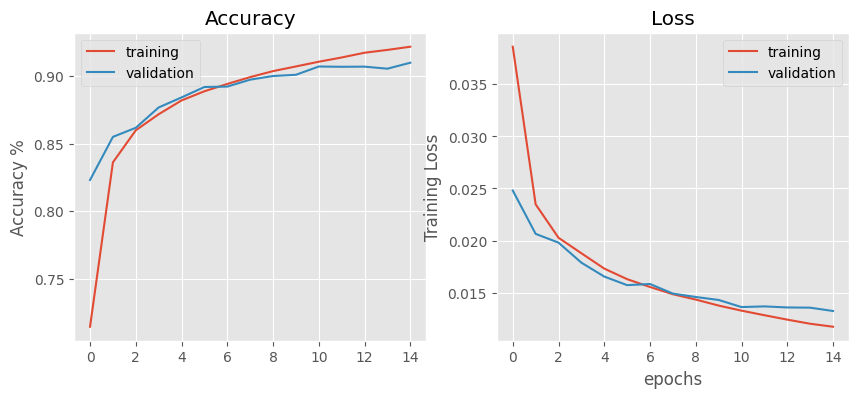

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [18]:
# want to train a few more epochs? We can
cnn2.fit(ds_train, batch_size=32, 
         epochs=3, shuffle=True, verbose=1,
         validation_data=ds_test)

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9249 - loss: 0.0112 - val_accuracy: 0.9135 - val_loss: 0.0127
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9261 - loss: 0.0110 - val_accuracy: 0.9101 - val_loss: 0.0131
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9272 - loss: 0.0107 - val_accuracy: 0.9156 - val_loss: 0.0124


In [19]:
cnn2.evaluate(ds_test,verbose=0)

[0.012440917082130909, 0.9156000018119812]

In [20]:
# want to save this model for later? We can save it with the .keras filename
# This will save:
#  - The model's architecture.
#  - The model's weights.
#  - The training configuration (loss, optimizer).
#  - The state of the optimizer, allowing for the resumption of training exactly where it was left off.
cnn2.save('large_data/mnist_cnn.keras')

36/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2025-11-13 12:12:44.958387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


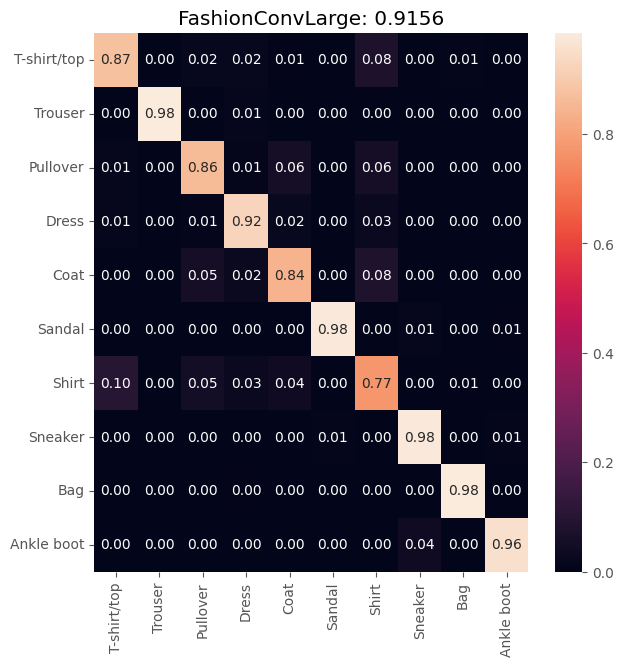

In [21]:
from tensorflow.keras.models import load_model

cnn_mnist = load_model('large_data/mnist_cnn.keras')
compare_models([cnn_mnist], ds_test, fig_size=(7,7), labels=labels)

______
In this notebook you learned:
 - Basic structure of building a keras sequential model
 - Building different CNN structures
 - Evaluating models with Keras and Sklearn
 - Tuning models, if desired for additional epochs
 - Saving and loading models in keras, with saved optimizer 